# How to Weight the White Flux Measurements

We recently found that the use of aperture flux measurements, when compared to PSF flux measurements, provides excellent discrimination for stars and galaxies. The catch in this case, however, is that due to a limited query the aperture fluxes were weighted using the PSF flux uncertainties. When weighting with the aperture flux measurements with the aperture flux uncertainties this discriminating power vanishes. 

This notebook investigates the effects and discriminating power that is possible with different weighting schemes [while only examining photometry from the stack catalog - the assumption is that these results generalize to the Mean and Forced photometry catalogs, but that is not proven].

In [2]:
import numpy as np
import pandas as pd
from astropy.io import fits
import matplotlib.pyplot as plt
%matplotlib notebook

In [122]:
hst_data = fits.getdata("HST_COSMOS_features_adamamiller.fit")
star = np.where(hst_data['MU_CLASS'] == 2)
gal = np.where(hst_data['MU_CLASS'] == 1)

To determine the weighted white flux for a source, an individual filter can only be included if the source is detected in that filter, where detection is defined as: 

  1. `PSFFlux > 0`
  2. `ApFlux > 0`
  3. `KronFlux > 0`

[As a brief side note - the same test for Mean and Forced photometry from PS1 needs to include `FluxErr` as well]

In [98]:
for filt in ['g','r','i','z','y']:
    exec("""det_{0} = np.logical_and.reduce((hst_data['{0}PSFFlux'] > 0, 
                                             hst_data['{0}ApFlux'] > 0, 
                                             hst_data['{0}KronFlux'] > 0))""".format(filt))
det_arr = np.vstack((det_g, det_r, det_i, det_z, det_y))

In [136]:
def calc_wwFlux(flux_type, weight_type, flux_table, det_arr):
    flux_arr = np.zeros_like(det_arr).astype(float)
    flux_unc_arr = np.zeros_like(det_arr).astype(float)
    for filtnum, filt in enumerate(['g','r','i','z','y']): 
        flux_col = filt + flux_type
        unc_col = filt + weight_type
        flux_arr[filtnum] = np.divide(flux_table[flux_col]**3, 
                                      flux_table[unc_col]**2, 
                                      where=det_arr[filtnum], 
                                      out=np.zeros_like(flux_table[flux_col]))
        flux_unc_arr[filtnum] = np.divide(flux_table[flux_col]**2, 
                                          flux_table[unc_col]**2,
                                          where=det_arr[filtnum],
                                          out=np.zeros_like(flux_table[flux_col]))
    return np.divide(np.sum(flux_arr, axis=0), 
                     np.sum(flux_unc_arr, axis=0), 
                     where=np.sum(flux_unc_arr, axis=0)>0, 
                     out=-999*np.ones_like(flux_unc_arr[0]))

### Compare flux ratios for different weighting schemes

We want to compare the difference in flux ratios (PSF/Kron and PSF/Ap) for stars and galaxies using different weighting schemes, as follows: (i) using the corresponding uncertainties, (ii) using the PSF uncertainties, (iii) using the Kron uncertainties, and (iv) using the Ap uncertainties.

<IPython.core.display.Javascript object>


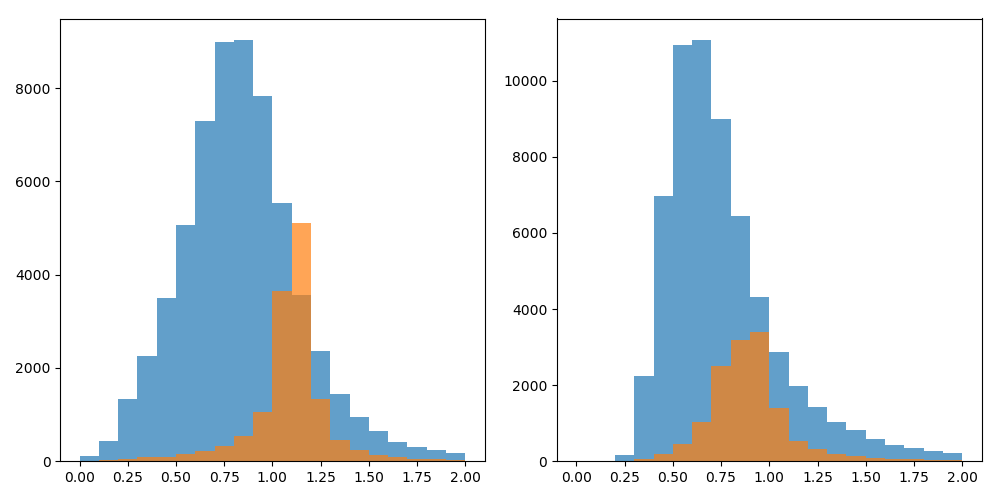

In [145]:
psf_psf_ww = calc_wwFlux('PSFFlux', 'PSFFluxErr', hst_data, det_arr)
kron_kron_ww = calc_wwFlux('KronFlux', 'KronFluxErr', hst_data, det_arr)
ap_ap_ww = calc_wwFlux('ApFlux', 'ApFluxErr', hst_data, det_arr)

psf_kron = psf_psf_ww/kron_kron_ww
psf_ap = psf_psf_ww/ap_ap_ww

star_det = np.logical_and(hst_data['MU_CLASS'] == 2, psf_psf_ww > 0)
gal_det = np.logical_and(hst_data['MU_CLASS'] == 1, psf_psf_ww > 0)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.hist(psf_kron[gal_det], bins=np.arange(0,2.1,0.1), alpha=0.7)
ax1.hist(psf_kron[star_det], bins=np.arange(0,2.1,0.1), alpha=0.7)
ax2.hist(psf_ap[gal_det], bins=np.arange(0,2.1,0.1), alpha=0.7)
ax2.hist(psf_ap[star_det], bins=np.arange(0,2.1,0.1), alpha=0.7)

fig.tight_layout()

<IPython.core.display.Javascript object>


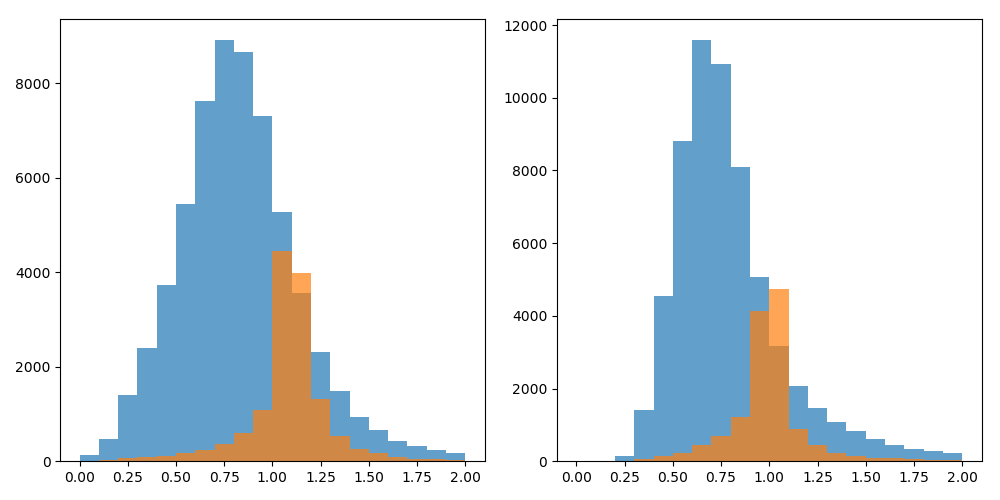

In [144]:
psf_psf_ww = calc_wwFlux('PSFFlux', 'PSFFluxErr', hst_data, det_arr)
kron_psf_ww = calc_wwFlux('KronFlux', 'PSFFluxErr', hst_data, det_arr)
ap_psf_ww = calc_wwFlux('ApFlux', 'PSFFluxErr', hst_data, det_arr)

psf_kron = psf_psf_ww/kron_psf_ww
psf_ap = psf_psf_ww/ap_psf_ww

star_det = np.logical_and(hst_data['MU_CLASS'] == 2, psf_psf_ww > 0)
gal_det = np.logical_and(hst_data['MU_CLASS'] == 1, psf_psf_ww > 0)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.hist(psf_kron[gal_det], bins=np.arange(0,2.1,0.1), alpha=0.7)
ax1.hist(psf_kron[star_det], bins=np.arange(0,2.1,0.1), alpha=0.7)
ax2.hist(psf_ap[gal_det], bins=np.arange(0,2.1,0.1), alpha=0.7)
ax2.hist(psf_ap[star_det], bins=np.arange(0,2.1,0.1), alpha=0.7)

fig.tight_layout()

<IPython.core.display.Javascript object>


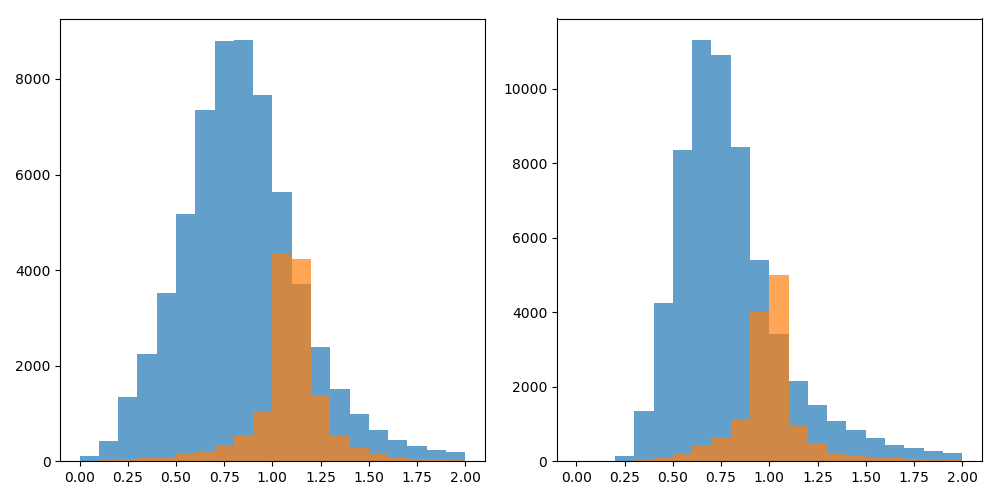

In [146]:
psf_kron_ww = calc_wwFlux('PSFFlux', 'KronFluxErr', hst_data, det_arr)
kron_kron_ww = calc_wwFlux('KronFlux', 'KronFluxErr', hst_data, det_arr)
ap_kron_ww = calc_wwFlux('ApFlux', 'KronFluxErr', hst_data, det_arr)

psf_kron = psf_kron_ww/kron_kron_ww
psf_ap = psf_kron_ww/ap_kron_ww

star_det = np.logical_and(hst_data['MU_CLASS'] == 2, psf_kron_ww > 0)
gal_det = np.logical_and(hst_data['MU_CLASS'] == 1, psf_kron_ww > 0)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.hist(psf_kron[gal_det], bins=np.arange(0,2.1,0.1), alpha=0.7)
ax1.hist(psf_kron[star_det], bins=np.arange(0,2.1,0.1), alpha=0.7)
ax2.hist(psf_ap[gal_det], bins=np.arange(0,2.1,0.1), alpha=0.7)
ax2.hist(psf_ap[star_det], bins=np.arange(0,2.1,0.1), alpha=0.7)

fig.tight_layout()

<IPython.core.display.Javascript object>


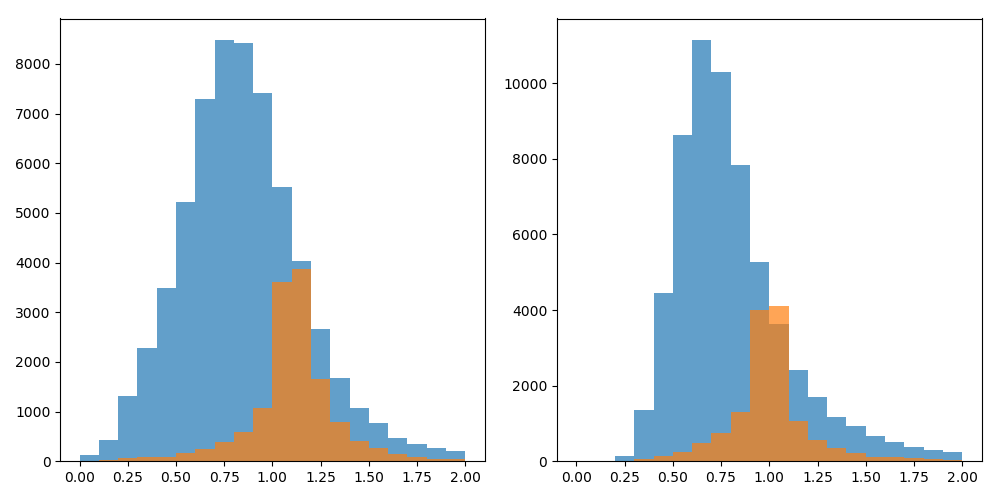

In [147]:
psf_ap_ww = calc_wwFlux('PSFFlux', 'ApFluxErr', hst_data, det_arr)
kron_ap_ww = calc_wwFlux('KronFlux', 'ApFluxErr', hst_data, det_arr)
ap_ap_ww = calc_wwFlux('ApFlux', 'ApFluxErr', hst_data, det_arr)

psf_kron = psf_ap_ww/kron_ap_ww
psf_ap = psf_ap_ww/ap_ap_ww

star_det = np.logical_and(hst_data['MU_CLASS'] == 2, psf_ap_ww > 0)
gal_det = np.logical_and(hst_data['MU_CLASS'] == 1, psf_ap_ww > 0)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.hist(psf_kron[gal_det], bins=np.arange(0,2.1,0.1), alpha=0.7)
ax1.hist(psf_kron[star_det], bins=np.arange(0,2.1,0.1), alpha=0.7)
ax2.hist(psf_ap[gal_det], bins=np.arange(0,2.1,0.1), alpha=0.7)
ax2.hist(psf_ap[star_det], bins=np.arange(0,2.1,0.1), alpha=0.7)

fig.tight_layout()

Based on this comparison PSFKron appears to do the best job of separating the stars and galaxies. 